In [3]:
import pandas as pd
import numpy as np

import torch
from torch import Tensor
import torch.nn.functional as F
from torch import nn
from torch.distributions import (Normal, StudentT, Poisson)
from uni2ts.distribution.negative_binomial import (NegativeBinomial)
from uni2ts.distribution import (MixtureOutput, 
                                 NormalOutput, 
                                 StudentTOutput,
                                LaplaceOutput, 
                                NormalFixedScaleOutput,
                                NegativeBinomialOutput, 
                                LogNormalOutput)
from utils.data_loader import create_cached_tsmixup_datasets
from load_cached_features import *
from utils.components import ResidualBlock
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import stdtrit
from scipy.stats import (poisson, nbinom)
from pytorch_forecasting.metrics.quantile import QuantileLoss
import einops

device = 'cuda:3'

In [4]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=128, # 1 or 128
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_128.pkl",
        batch_size=4000
    )

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y

In [3]:
# Load Training Dataset
model_name = "yinglong"
file_name_dict = {
    "timesfm": "./data/timesfm_cache_last_fp16/last_shard_*.pt",
    "chronos_bolt": "./data/chronos_bolt_cache_fp16/squeeze_shard_*.pt",
    "moirai2": "./data/moirai2_cache_fp16/last_shard_*.pt",
    "tirex": "./data/tirex_cache_fp16/full_shard_*.pt",
    "yinglong": "./data/yinglong_cache_fp16/full_shard_*.pt",
}
data_fn = file_name_dict[model_name]
train_ds = FullLatentShardDataset(data_fn)

In [ ]:
class MixtureHead(nn.Module):
    """
    Wrap a backbone (e.g., ResidualBlock) and a uni2ts DistrParamProj derived from MixtureOutput.
    Forward returns the parameter PyTree ready to instantiate a Mixture distribution.
    """
    def __init__(self, in_features: int, hidden_dims: int, horizon_len: int, mixture_output: MixtureOutput):
        super().__init__()
        # Your backbone to process latents
        self.backbone = ResidualBlock(
            input_dims=in_features,
            output_dims=in_features,       # keep embedding size unchanged
            hidden_dims=hidden_dims,
        )
        # Project backbone features -> mixture parameters for each horizon step
        self.param_proj = mixture_output.get_param_proj(
            in_features=in_features,
            out_features=tuple(horizon_len for _ in range(len(mixture_output.components))),      # produce per-step parameters
            # You can pass proj_layer/kwargs if you want a different projector
        )
        self.mixture_output = mixture_output

    def forward(self, latents: torch.Tensor, out_feat_size: torch.Tensor):
        """
        latents: [B, D] or [B, D'] depending on TimesFM latent shape you used elsewhere
        returns: pytree of parameters (already passed through domain_map, squeezed to [B, H])
        """
        h = self.backbone(latents)
        params = self.param_proj(h, out_feat_size)  # PyTree with shapes [B, H, param_dim] -> domain_map squeezes to [B, H]
        return params

In [5]:
eps = 1e-6
def get_mask(latents: Tensor, labels: Tensor, max_val: int, min_val: int):
    nan_mask = ~torch.isfinite(latents) # if nan
    clamp_mask = (labels > max_val) | (labels < min_val) # if outside min/max
    mask = ~(torch.any(nan_mask, dim=1) | torch.any(clamp_mask, dim=1))
    return mask

def get_preds(model: nn.Module, latents: Tensor, horizon_len: int = 128, output_dims: int = 1,
              reshape: bool = True):
    out = model(latents)  # [B, horizon_len * output_dims]
    if reshape:
        if out.ndim == 3:
            out = einops.rearrange(out, "batch patches (patch_len output_dims) -> batch (patches patch_len) output_dims",
            output_dims = output_dims)
        else:
            out = einops.rearrange(out, "batch (horizon_len output_dims) -> batch horizon_len output_dims",
                                   horizon_len=horizon_len, output_dims=output_dims)
    return out

def get_batch(dataset: torch.utils.data.Dataset, batch_num: int, batch_size: int, device: str):
    latents, stats, labels = [], [], []
    for i in range(batch_size):
        dataset_ind = batch_num + i
        latent, stat, label = dataset[dataset_ind]
        latents.append(latent)
        stats.append(stat)
        labels.append(label)
    latents = torch.stack(latents).to(device).float()
    stats   = torch.stack(stats).to(device)
    labels  = torch.stack(labels).to(device)
    return latents, stats, labels

def mixture_quantiles_by_sampling(dist, qs, num_samples=4096):
    # dist: uni2ts.mixture.Mixture distribution, batch shape [B, H]
    # qs: sequence like [0.1, 0.5, 0.9]
    with torch.no_grad():
        samples = dist.sample((num_samples,))  # [S, B, H]
        # torch.quantile expects a tensor of probs on same device
        q_tensor = torch.tensor(qs, device=samples.device, dtype=samples.dtype)
        q_vals = torch.quantile(samples, q_tensor, dim=0)  # [Q, B, H]
    return q_vals  # [Q, B, H]

def latent_forecast(pred_head: nn.Module, latents: Tensor, horizon_len: int, head_type: str, 
                    output_dims: int | None = None, labels: Tensor | None = None, 
                    mu0: Tensor | None = None, sigma0: Tensor | None = None,
                    quantiles: list[float] | None = None, forecast: bool = True, 
                    mixture_output: MixtureOutput | None = None):
    if quantiles == None:
        quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = {}
    if output_dims == None:
        output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 3, 
                            "quantiles": 9, "mixture": 128}
        output_dims = output_dims_dict[head_type]
    
    if head_type != "mixture":
        out = get_preds(pred_head, latents, horizon_len, output_dims) # [B, H, D]
    if head_type == "mse":
        pred = out[:, :, 0] # [B, H]
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            pred = pred * sigma0[:, None] + mu0[:, None]
        if torch.is_tensor(labels):
            loss = F.mse_loss(pred, labels)
            results["loss"] = loss
        if forecast:
            results["mean"] = pred.detach().cpu()
            results["median"] = pred.detach().cpu()

    elif head_type == "quantiles":
        pred = out # [B, H, Q]
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            pred = pred * sigma0[:, None, None] + mu0[:, None, None]
        if torch.is_tensor(labels):
            loss = QuantileLoss(quantiles).loss(pred, labels).mean()
            results["loss"] = loss
        if forecast:
            results["median"] = pred[:, :, 4].detach().cpu()
            results["mean"] = pred[:, :, 4].detach().cpu()
            results["quantiles"] = einops.rearrange(pred.detach().cpu(), "B H Q -> Q B H")
            
    elif head_type == "mixture":
        assert mixture_output is not None, "mixture_output must be provided for head_type='mixture'"

        # 1) Predict mixture parameters
        # pred_head is MixtureHead and returns a PyTree with keys:
        #   "weights_logits" -> [B, H, K]
        #   "components" -> list of dicts with the per-component parameters ([B, H])
        if latents.ndim == 3:
            out_feat_size = torch.full([latents.shape[0]], horizon_len // latents.shape[1], dtype=int, device=latents.device)
            n_patches = latents.shape[1]
            latents = einops.rearrange(latents, "B patches d_model -> (B patches) d_model")
        else:
            n_patches = 0
            out_feat_size = torch.full([latents.shape[0]], horizon_len, dtype=int, device=latents.device)
        params = pred_head(latents, out_feat_size)

        # 2a) TRAINING: If you trained on normalized labels (continuous):
        #     Use dist on normalized space (no affine transform).
        # 2b) TRAINING (counts): keep labels as integers and use as-is.
        if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
            if n_patches > 0: # repeat for added dimension
                mu0 = mu0.repeat_interleave(n_patches, dim=0)
                sigma0 = sigma0.repeat_interleave(n_patches, dim=0)
            dist = mixture_output.distribution(
                params,
                loc=mu0[:, None],     # [B, 1] -> broadcast to [B, H]
                scale=sigma0[:, None]
            )
        else:
            dist = mixture_output.distribution(params)

        if torch.is_tensor(labels):
            loss = -dist.log_prob(labels).mean()
            results["loss"] = loss

        if forecast:
            # 3) FORECAST: return distribution in original units by affine transform (if you used normalized training)
            with torch.no_grad():
                mean = dist.mean.detach().cpu()  # [B, H]
                # quantiles via sampling
                median_quantiles = [0.5] + quantiles
                q_vals = mixture_quantiles_by_sampling(dist, median_quantiles, num_samples=4096).cpu()  # [1+Q, B, H]
                if n_patches > 0:
                    mean = einops.rearrange(mean, "(B patches) patch_len -> B (patches patch_len)", patches=n_patches)
                    q_vals = einops.rearrange(q_vals, "Q (B patches) patch_len -> Q B (patches patch_len)", patches=n_patches)
                results["mean"] = mean
                results["median"] = q_vals[0] 
                results["quantiles"] = q_vals[1:]

    else: # distribution loss
        if head_type == "gaussian":
            pred_mu = out[:, :, 0]
            pred_std = F.softplus(out[:, :, 1]) + eps
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_mu = pred_mu * sigma0[:, None] + mu0[:, None]
                pred_std = pred_std * sigma0[:, None]
            distribution = Normal(pred_mu, pred_std)

        elif head_type == "poisson":
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_lambda = F.softplus(out[:, :, 0] + torch.log(mu0[:, None].clamp_min(eps))) + eps
            else:
                pred_lambda = F.softplus(out[:, :, 0]) + eps
            distribution = Poisson(pred_lambda)

        elif head_type == "neg_binom":
            pred_mu =  torch.exp(out[:, :, 0]) + eps # any real
            pred_r = F.softplus(out[:, :, 1])  + eps # dispersion > 0
            if torch.is_tensor(mu0):
                pred_mu = pred_mu * mu0[:, None].clamp_min(eps)
            pred_p = pred_r / (pred_r + pred_mu) # Pytorch/Scipy
            # distribution = NegativeBinomial(total_count=pred_r, probs=pred_p) # Pytorch
            pred_logits = torch.log(pred_mu / pred_r)
            distribution = NegativeBinomial(total_count=pred_r, logits=pred_logits)
            
        elif head_type == "studentst":
            pred_df = F.softplus(out[:, :, 0]) + eps
            pred_mu = out[:, :, 1]
            pred_std = F.softplus(out[:, :, 2]) + eps
            if torch.is_tensor(mu0) and torch.is_tensor(sigma0):
                pred_mu = pred_mu * sigma0[:, None] + mu0[:, None]
                pred_std = pred_std * sigma0[:, None]
            distribution = StudentT(pred_df, loc=pred_mu, scale=pred_std)
        else:
            raise KeyError(f"{head_type} is not a valid distribution or loss")
        if torch.is_tensor(labels):
            if head_type == "poisson":
                loss = F.poisson_nll_loss(pred_lambda, labels, log_input=False)
            else:
                loss = -distribution.log_prob(labels).mean()
            results["loss"] = loss
        if forecast:
            results["mean"] = distribution.mean.detach().cpu()
            if head_type in  ("studentst", "poisson", "neg_binom"):
                median_quantiles = [0.5] + quantiles
                p = torch.tensor(median_quantiles)[:, None, None] * \
                    torch.ones((len(median_quantiles), out.shape[0], out.shape[1]))
                if head_type == "studentst":
                    preds = stdtrit(pred_df.detach().cpu().repeat(len(median_quantiles), 1, 1), p)
                    preds = preds * pred_std.detach().cpu() + pred_mu.detach().cpu()
                if head_type == "poisson":
                    preds = poisson.ppf(p, pred_lambda.detach().cpu().repeat(len(median_quantiles), 1, 1))
                if head_type == "neg_binom":
                    preds = nbinom.ppf(p, pred_r.detach().cpu().repeat(len(median_quantiles), 1, 1), 
                                       pred_p.detach().cpu().repeat(len(median_quantiles), 1, 1))
                results["median"] = preds[0]
                results["quantiles"] = preds[1:]

            else:
                results["median"] = distribution.icdf(0.5*torch.ones_like(out[:,:,0])).detach().cpu()
                quantiles_torch = torch.tensor(quantiles).repeat(out.shape[0], out.shape[1], 1)
                results["quantiles"] = distribution.icdf(quantiles_torch).detach().cpu()

    return results
            


In [ ]:
# Standard Head
# Quantiles, StudentsT, Gaussian, MOIRAI V1 Mixture, Gaussian Mixture*, Spline*, Chronos V1 Categorical*
# "mse", "gaussian", "poisson", "neg_binom", "studentst", "quantiles", "mixture"
head_type = "quantiles"
patch_len_dict = {
    "timesfm": 32,
    "chronos_bolt": 32,
    "moirai2": 16,
    "tirex": 32,
    "yinglong": 32
}
patch_len = patch_len_dict[model_name]
intermediate_size = 1280
batch_size = 512
hidden_size_dict = {
    "timesfm": 1280,
    "chronos_bolt": 768,
    "moirai2": 384,
    "tirex": 512,
    "yinglong": 768,
}
hidden_size = hidden_size_dict[model_name]
horizon_dict = {
    "timesfm": 128,
    "chronos_bolt": 64,
    "moirai2": 64,
    "tirex": 128,
    "yinglong": 128,
}
horizon_len = horizon_dict[model_name]
step_size_dict = {
    "timesfm": 128,
    "chronos_bolt": 64,
    "moirai2": 64,
    "tirex": 32,
    "yinglong": 32,
}
step_size = step_size_dict[model_name]
output_dims_dict = {"mse": 1, "gaussian": 2, "poisson": 1, "neg_binom": 2, "studentst": 3, "quantiles": 9, "mixture": None}
count_heads = ("poisson", "neg_binom")
output_dims = output_dims_dict[head_type]
context_len = 512

# Mixture Distribution

if head_type == "mixture":
    # MOIRAI V1 Mixture Components
    components = [ 
        StudentTOutput(),
        NormalFixedScaleOutput(),
        NegativeBinomial(),
        LogNormalOutput(),
    ]
    mixture_output = MixtureOutput(components)
    K = len(components)
    pred_head = MixtureHead(
            in_features=hidden_size,
            hidden_dims=intermediate_size,
            horizon_len=step_size,
            mixture_output=mixture_output
        ).to(device).train()
else:
    mixture_output = None
    pred_head = ResidualBlock(
            input_dims=hidden_size,
            output_dims=step_size*output_dims,
            hidden_dims=intermediate_size,
        ).to(device).train()
save_path = f"models/{model_name}_{head_type}_head.pt"

# pred_head = torch.nn.Linear(hidden_size, horizon_len*output_dims).to(device).train()

optimizer = torch.optim.AdamW(pred_head.parameters(), lr=3e-4, weight_decay=1e-2)
grad_clip = 1.0
scaler = torch.amp.GradScaler()

logvar_min, logvar_max = -10.0, 10.0              # normalized log-variance bounds
sigma_floor, sigma_ceiling = 1e-6, 1e6            # per-sample sigma bounds in original units
var_floor, var_ceiling = 1e-12, 1e12              # final variance bounds
min_std_norm = 0.05                               # floor on normalized std (pre sigma scaling)
max_label = 1000                                  # If Label is greater remove as an outlier
min_label = -1000 if head_type not in count_heads else 0

training_loss = []

In [ ]:
# Training setup
loss_batch = []
tfm_loss_batch = []
tot_iters = 2097152
epochs = 3
for epoch in tqdm(range(epochs), desc="Epochs", disable=True):
    pbar = tqdm(range(0, tot_iters, batch_size), desc=f"Epoch: {epoch}", leave=True)
    for batch_num in pbar:
        latents, stats, labels = get_batch(train_ds, batch_num, batch_size, device)
        # latents [B, d_model] or [B, num_patches, d_model]
        # stats [B, 2]
        # labels [B, pred_len]
        if model_name == "tirex" or model_name == "yinglong":
            latents = einops.rearrange(latents, "B patches d_model -> B (patches d_model)")
        mask = get_mask(latents, labels, max_label, min_label)

        if torch.any(mask == 0):
            latents = latents[mask]
            stats = stats[mask]
            labels = labels[mask]
            # print(f"Reduced batch_size from {batch_size} to {latents.shape[0]}")
        

        # Set up norm
        mu0    = stats[:, 0].float()                                # [B]
        sigma0 = stats[:, 1].float()                                # [B]
        labels_norm = (labels.float() - mu0[:, None]) / (sigma0[:, None] + eps)       # [B, H]

        
        if model_name == "tirex" or model_name == "yinglong":
            latents = einops.rearrange(latents, " B (patches d_model) -> B patches d_model",
                                      d_model = hidden_size)

        optimizer.zero_grad(set_to_none=True)


        # print(f"isfinite: latents {torch.isfinite(latents).all()} count: {torch.count_nonzero(torch.logical_not(torch.isfinite(latents)))}")
        # # print(f"isfinite: y {torch.isfinite(y).all()}, min {y.min():.2e} max {y.max():.2e} q(0.999) {torch.quantile(y, 0.999):.2e}")
        # print(f"isfinite: labels {torch.isfinite(labels).all()}, min {labels.min():.2e} max {labels.max():.2e} q(0.999) {torch.quantile(labels, 0.999):.2e}")
        # print(f"isreal: labels {torch.isreal(labels).all()}  count: {torch.count_nonzero(torch.logical_not(torch.isreal(labels)))}")
        # print(f"isfinite: labels_norm {torch.isfinite(labels_norm).all()}, min {labels_norm.min():.2e} max {labels_norm.max():.2e} q(0.999) {torch.quantile(labels_norm, 0.999):.2e}")
        # print(f"isreal: labels_norm {torch.isreal(labels_norm).all()}  count: {torch.count_nonzero(torch.logical_not(torch.isreal(labels_norm)))}")
        # print(f"isfinite: sigma0 {torch.isfinite(sigma0).all()}, min {sigma0.min():.2e} max {sigma0.max():.2e} q(0.999) {torch.quantile(sigma0, 0.999):.2e}")
        # print(f"isZero: sigma0 {(sigma0 == 0).all()}, abs(min) {abs(sigma0).min():.2e} abs(max) {abs(sigma0).max():.2e} abs q(0.999) {torch.quantile(abs(sigma0), 0.999):.2e}")
        # print(f"isfinite: mu0 {torch.isfinite(mu0).all()}, min {mu0.min():.2e} max {mu0.max():.2e} q(0.999) {torch.quantile(mu0, 0.999):.2e}")

        results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                    output_dims, forecast=False,
                    labels=labels if head_type in count_heads else labels_norm,
                    mu0=mu0 if head_type in count_heads else None,
                    sigma0=sigma0 if head_type in count_heads else None,
                    mixture_output=mixture_output)
        loss = results["loss"]
        loss_batch.append(loss.item())

        # Backward with AMP
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(pred_head.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        # print(f"loss: {loss.item()}")
        # Logging
        log_batch = (batch_size * (1024 // 4))
        if (batch_num % log_batch) == (log_batch - batch_size):
            train_med_loss = np.median(np.array(loss_batch))
            loss_batch = []
            pbar.set_description(f"epoch: {epoch} batch_num: {batch_num // batch_size + 1}/{tot_iters // batch_size} loss: {train_med_loss:.4f}") 
            # print(f"epoch: {epoch} batch_num: {batch_num // batch_size} loss: {train_med_loss:.4f}")
            training_loss.append(train_med_loss)

torch.save(pred_head.state_dict(), save_path)

epoch: 2 batch_num: 3072/3072 loss: 0.4401: 100%|██████████| 3072/3072 [00:43<00:00, 70.28it/s]


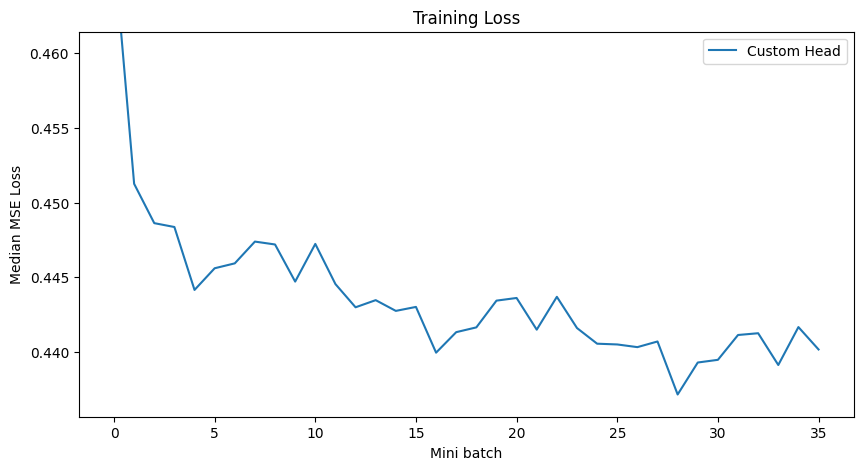

In [11]:
# Plot Training Loss
plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Custom Head")
plt.legend()
plt.xlabel("Mini batch")
plt.ylabel("Median MSE Loss")
plt.title("Training Loss")
plt.ylim(top=np.quantile(training_loss, 0.99))
plt.show()

In [7]:
def load_model(model_name):
    if model_name == "timesfm":
        import timesfm
        pred_len = 128
        model = timesfm.TimesFm(
                hparams=timesfm.TimesFmHparams(
                    backend='gpu',
                    # per_core_batch_size=32,
                    context_len=context_len,  # currently max supported
                    horizon_len=pred_len,  # number of steps to predict
                    input_patch_len=32,  # fixed parameters
                    output_patch_len=128,
                    num_layers=50,
                    model_dims=1280,
                    use_positional_embedding=False,
                    point_forecast_mode='mean',
                    device=device
                ),
                checkpoint=timesfm.TimesFmCheckpoint(
                    huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
            )
        model._model.eval()
        if device is not None:
            model._model.to(device)
    elif model_name == "moirai":
        from uni2ts.model.moirai import (MoiraiForecast, MoiraiModule)
        pred_len = 128
        model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
            prediction_length=pred_len,
            context_length=context_len,
            patch_size=32,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
        moirai = model.module
        moirai.get_reprs = True
        moirai.eval()
        if device is not None:
            moirai.to(device)
    elif model_name == "moirai2":
        from uni2ts.model.moirai2 import (Moirai2Forecast, Moirai2Module)
        pred_len = 64
        model = Moirai2Forecast(
            module=Moirai2Module.from_pretrained(
                f"Salesforce/moirai-2.0-R-small",
            ),
            prediction_length=pred_len,
            context_length=context_len,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
        moirai = model.module
        moirai.eval()
        if device is not None:
            moirai.to(device)
    elif model_name == "chronos_bolt":
        from chronos import ChronosBoltPipeline
        pred_len = 64
        model = ChronosBoltPipeline.from_pretrained(
            "amazon/chronos-bolt-base",
            device_map=device,
            torch_dtype=torch.bfloat16,
        )
        model.model.eval()
    elif model_name == "tirex":
        from tirex import load_model as load_tirex_model
        pred_len = 128
        model = load_tirex_model("NX-AI/TiRex")
    elif model_name == "yinglong":
        from transformers import AutoModelForCausalLM
        pred_len = 128
        model = AutoModelForCausalLM.from_pretrained('qcw2333/YingLong_110m', trust_remote_code=True,torch_dtype=torch.bfloat16).to(device)

    return model

def get_preds_latents(model, context, pred_len):
    if model_name == "timesfm":
        freq = [0] * len(context)
        _, quantile_forecasts, (transformer_output, stats) = model.forecast(
            context, freq=freq, get_stacked_transformer=True
        )  # transformer_output: [B, N, 1280], stats: [B, 2]
        transformer_output = transformer_output[:,-1,:]

    elif "moirai" in model_name:
        context = context.to(device)[:, :, None]
        target, observed_mask, sample_id, time_id, variate_id, prediction_mask = model._convert(
            patch_size=patch_len,
            past_target=context,                                 # B x past_time x D
            past_observed_target=torch.isfinite(context),               # B x past_time x D (bool)
            past_is_pad=torch.full_like(context[:, :, 0], False, dtype=bool),                                 # B x past_time (bool)
        )
        if model_name == "moirai2":
            patch_sizes = False
        else:
            patch_sizes = torch.ones_like(time_id, dtype=torch.long) * patch_len
        model.module.get_reprs = True
        transformer_output, stats = model.module(
            target,
            observed_mask,
            sample_id,
            time_id,
            variate_id,
            prediction_mask,
            patch_sizes)
        transformer_output = transformer_output[prediction_mask].reshape([batch_size, -1, transformer_output.shape[-1]])
        stats = stats[prediction_mask].reshape([batch_size, -1, stats.shape[-1]])
        model.module.get_reprs = False
        forecasts = model.module(
            target,
            observed_mask,
            sample_id,
            time_id,
            variate_id,
            prediction_mask,
            patch_sizes)
        quantile_forecasts = einops.rearrange(forecasts[:,context_len//patch_size,:],
                                "B (pred_len quantiles) -> B pred_len quantiles",
                                quantiles = 9, pred_len = pred_len)
        
    elif model_name == "chronos_bolt":
        transformer_output = torch.zeros(context.shape[0], model.model.model_dim)
        stats = torch.zeros(context.shape[0], 2)            
        def save_decoder_hook(module, input, output):
            transformer_output[:] = output.last_hidden_state.squeeze().detach().cpu()
            
        def save_encoder_hook(module, input, output):
            stats[:] = torch.stack(output[1], dim=-1).squeeze().detach().cpu()

        model.model.decoder.register_forward_hook(save_decoder_hook)
        model.model.instance_norm.register_forward_hook(save_encoder_hook)
        context = context.to(device)
        forecasts = model.model(context)
        quantile_forecasts = forecasts.quantile_forecasts

    elif model_name == "tirex":
        d_model = model.model_config.block_kwargs.embedding_dim
        patch_size = model.model_config.output_patch_size
        out_patches = pred_len // patch_size
        transformer_output = torch.zeros(context.shape[0], out_patches, d_model)
        stats = torch.zeros((context.shape[0], 2))
        forecasts = model.forecast(context=context, prediction_length=pred_len, batch_size=batch_size,
                                            max_accelerated_rollout_steps=4, 
                                            get_loc_scale=stats,
                                            get_hidden_states=transformer_output)
        quantile_forecasts = forecasts[0]
    
    elif model_name == "yinglong":
        context = context.to(device)
        d_model = model.config.n_embd # 768
        patch_size = model.config.patch_size # 32
        out_patches = pred_len // patch_size
        transformer_output = torch.zeros((context.shape[0], out_patches, d_model))
        stats = torch.zeros((context.shape[0], 2))
        start_ind = context.shape[0] // patch_size
        end_ind = start_ind + out_patches
        def save_decoder_hook(module, input, output):
            transformer_output[:] = input[0][:,start_ind:end_ind].detach().cpu()
        def save_tokenizer_hook(module, input, output):
            x, x_raw, masks, mean, std, _ = output
            stats[:,0] = mean.flatten().detach().cpu()
            stats[:,1] = std.flatten().detach().cpu()
        if hasattr(model.lm_head, "_forward_hooks"):
            model.lm_head._forward_hooks.clear()
        if hasattr(model.tokenizer, "_forward_hooks"):
            model.tokenizer._forward_hooks.clear()
        model.lm_head.register_forward_hook(save_decoder_hook)
        model.tokenizer.register_forward_hook(save_tokenizer_hook)
        forecast_len = 2048 # large number for DCoT
        forecasts = model.generate(context, future_token=forecast_len)
        quantile_forecasts = forecasts[:,:pred_len,[9,19,29,39,49,59,69,79,89]].float().detach().cpu()

    return quantile_forecasts, transformer_output, stats
    

model = load_model(model_name)

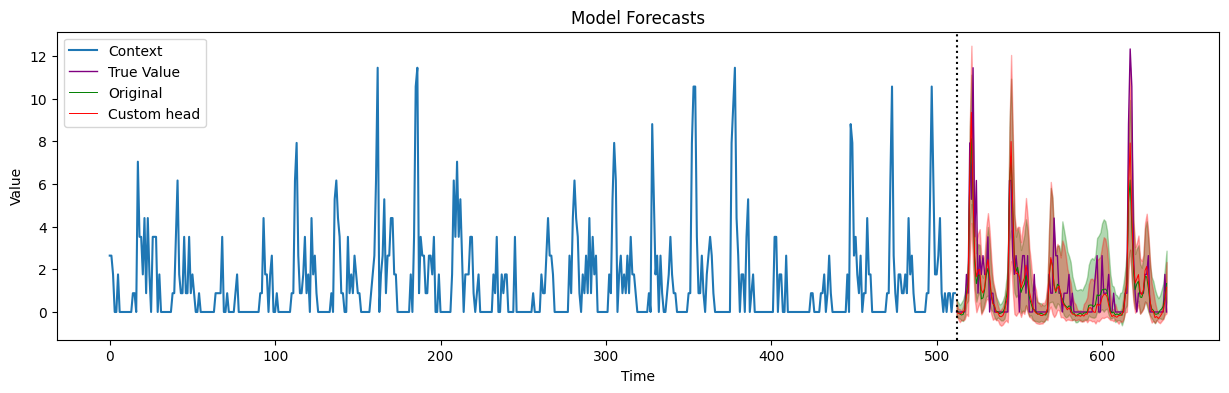

In [65]:
# Plot Examples
pred_head.load_state_dict(torch.load(save_path))
x, y = load_dataset('tsmixup', np.random.randint(0, 10000, batch_size), pred_length=horizon_len, ctx_len=context_len)
# Load Latents
# tfm_pred, tfm_quantiles, (latents, stats) = tfm.forecast(x, get_stacked_transformer=True)
quantiles, latents, stats = get_preds_latents(model, x, horizon_len)
latents = latents.to(device)
stats = stats.to(device)

mu0    = stats[:, 0].float()                                # [B]
sigma0 = stats[:, 1].float()

results = latent_forecast(pred_head, latents, horizon_len, head_type, 
                          output_dims, mu0=mu0, sigma0=sigma0, 
                          mixture_output=mixture_output)

head_pred = results["mean"]
head_q10 = results["quantiles"][0] 
head_q90 = results["quantiles"][-1]

ind = 2
plt.figure(figsize=(15,4))
plt.plot(x[ind], label="Context")
plt.plot(np.arange(y.shape[1]) + context_len, y[ind].detach().cpu(), color='purple', label='True Value', lw=1)

plt.plot(np.arange(quantiles.shape[1]) + context_len, quantiles[ind, :, 4], color='green', label='Original', lw=0.7)
plt.fill_between(np.arange(quantiles.shape[1]) + context_len, quantiles[ind, :, 1], quantiles[ind, :, -1], color='green', alpha=0.3)

plt.plot(np.arange(head_pred.shape[1]) + context_len, head_pred[ind].detach().cpu(), color='red', label='Custom head', lw=0.7)
plt.fill_between(np.arange(head_pred.shape[1]) + context_len, head_q10[ind], head_q90[ind], color='red', alpha=0.3)

plt.axvline(context_len, color="black", ls=':')
plt.title("Model Forecasts")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()